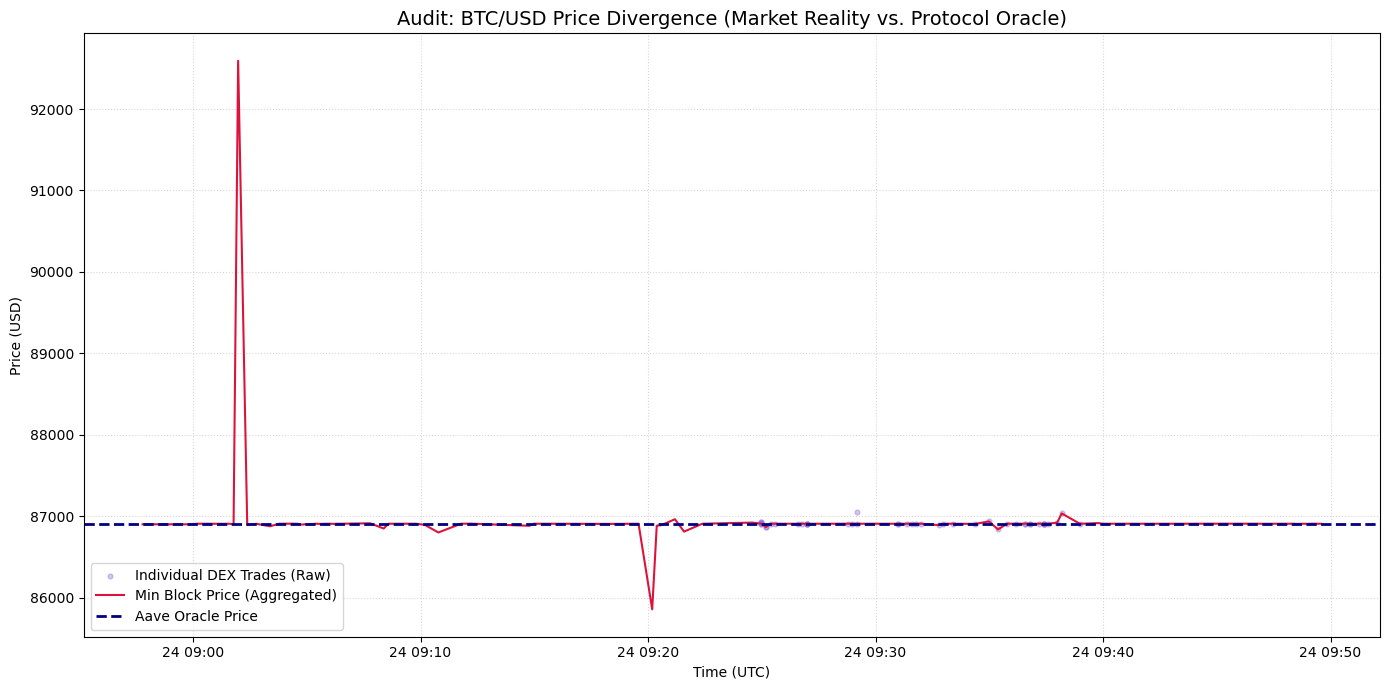

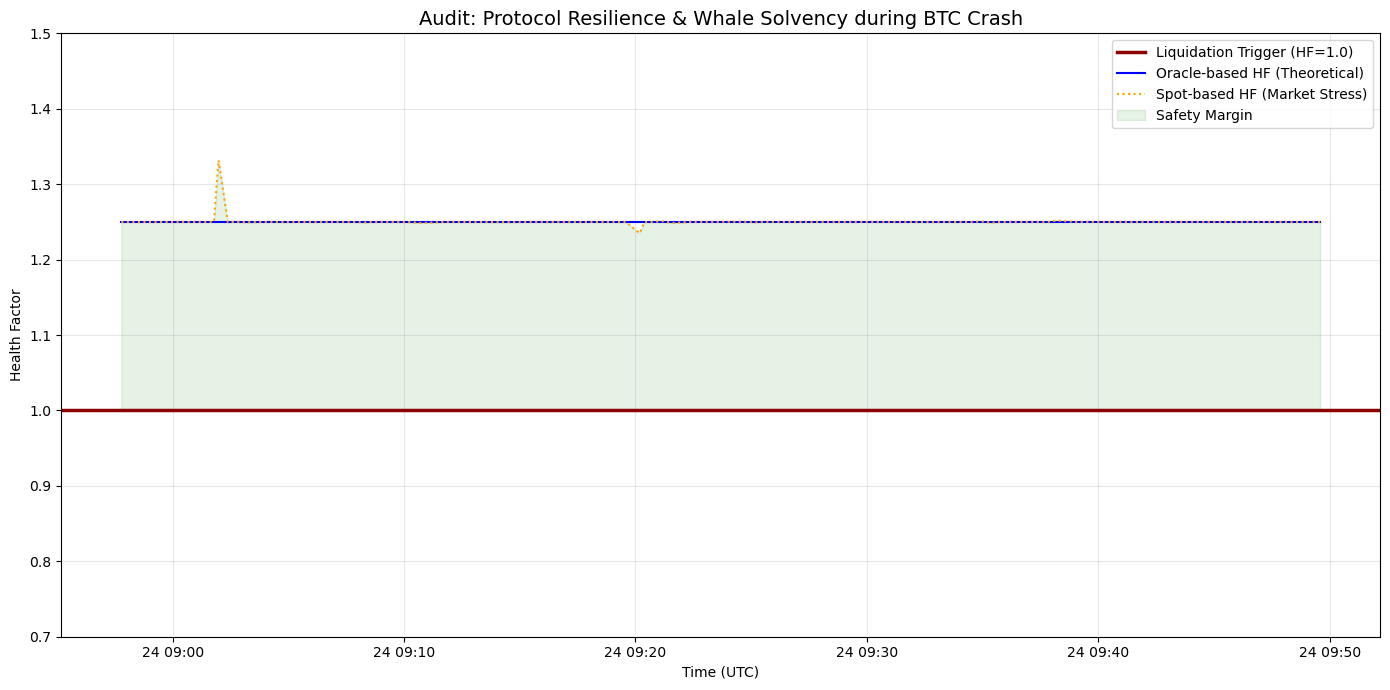

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data ---
# Updated file paths to reflect new naming convention
file_raw_trades = '01_raw_dex_trades.csv' 
file_block_agg = '02_block_aggregation.csv'

df_raw = pd.read_csv(file_raw_trades)
df_blocks = pd.read_csv(file_block_agg)

# --- 2. Robust Timestamp Normalization (Fixed DateParseError) ---
def parse_normalized_time(time_str):
    """
    Ensures all timestamps are ISO compliant. 
    Prevents double-prepending if the date '2025' is already present.
    """
    time_str = str(time_str).strip()
    
    # If the date is already present (e.g. '2025-12-24T...'), return as is
    if '2025' in time_str:
        return time_str
    
    # If only MM:SS.f is present
    if len(time_str.split(':')) == 2:
        return f"2025-12-24 09:{time_str}"
    # If only HH:MM:SS is present
    elif len(time_str.split(':')) == 3:
        return f"2025-12-24 {time_str}"
        
    return time_str

# Apply corrected normalization
df_blocks['BLOCK_TIMESTAMP'] = pd.to_datetime(df_blocks['BLOCK_TIMESTAMP'].apply(parse_normalized_time))
df_raw['BLOCK_TIMESTAMP'] = pd.to_datetime(df_raw['BLOCK_TIMESTAMP'].apply(parse_normalized_time))

# Sort chronologically
df_blocks = df_blocks.sort_values('BLOCK_NUMBER')

# --- 3. Audit Parameters ---
ORACLE_PRICE_BASE = 86908.0  
LIQUIDATION_THRESHOLD = 0.83 
DEBT_USD = 50_000_000 
TARGET_HF = 1.25

# Calculate initial collateral needed for the whale simulation
collateral_wbtc = (TARGET_HF * DEBT_USD) / (ORACLE_PRICE_BASE * LIQUIDATION_THRESHOLD)

# Calculate Health Factors (HF)
df_blocks['ORACLE_HF'] = (collateral_wbtc * ORACLE_PRICE_BASE * LIQUIDATION_THRESHOLD) / DEBT_USD
df_blocks['SPOT_HF'] = (collateral_wbtc * df_blocks['MIN_PRICE'] * LIQUIDATION_THRESHOLD) / DEBT_USD

# --- 4. Visualization 1: Price Divergence Audit ---
plt.figure(figsize=(14, 7))
plt.scatter(df_raw['BLOCK_TIMESTAMP'], df_raw['BTC_SPOT_PRICE_USD'], 
            alpha=0.4, s=12, color='mediumpurple', label='Individual DEX Trades (Raw)')
plt.plot(df_blocks['BLOCK_TIMESTAMP'], df_blocks['MIN_PRICE'], 
         color='crimson', linewidth=1.5, label='Min Block Price (Aggregated)')
plt.axhline(y=ORACLE_PRICE_BASE, color='navy', linestyle='--', linewidth=2, label='Aave Oracle Price')

plt.title('Audit: BTC/USD Price Divergence (Market Reality vs. Protocol Oracle)', fontsize=14)
plt.xlabel('Time (UTC)')
plt.ylabel('Price (USD)')
plt.legend(loc='lower left')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 5. Visualization 2: Whale Solvency Audit ---
plt.figure(figsize=(14, 7))
plt.axhline(y=1.0, color='darkred', linestyle='-', linewidth=2.5, label='Liquidation Trigger (HF=1.0)')
plt.plot(df_blocks['BLOCK_TIMESTAMP'], df_blocks['ORACLE_HF'], label='Oracle-based HF (Theoretical)', color='blue')
plt.plot(df_blocks['BLOCK_TIMESTAMP'], df_blocks['SPOT_HF'], label='Spot-based HF (Market Stress)', color='orange', linestyle=':')
plt.fill_between(df_blocks['BLOCK_TIMESTAMP'], 1.0, df_blocks['SPOT_HF'], 
                 where=(df_blocks['SPOT_HF'] > 1.0), color='green', alpha=0.1, label='Safety Margin')

plt.title('Audit: Protocol Resilience & Whale Solvency during BTC Crash', fontsize=14)
plt.xlabel('Time (UTC)')
plt.ylabel('Health Factor')
plt.ylim(0.7, 1.5)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()